# 시카고 범죄율을 예측해 보자 ( Facebook 의 Prophet 라이브러리 활용 )





# STEP #0: PROBLEM STATEMENT

이미지넷 
참고: https://bskyvision.com/425
이미지넷  사진을 분류하는 경진대회

transfer learning 기존 잘 만들어진 딥러닝 모델링을 이용해서 (대회에서 우승한 ai)  
(w값 등을 그대로 가져온다, Trainable Layers 부분을 수정해서 사용)

그러면 빠른시간안에 성능이 좋은 인공지능을 만들 수 있음

- The Chicago Crime dataset : 2001 ~ 2017. 
- Datasource: 캐글 https://www.kaggle.com/currie32/crimes-in-chicago
- Dataset contains the following columns: 
    - ID: Unique identifier for the record.
    - Case Number: The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
    - Date: Date when the incident occurred.
    - Block: address where the incident occurred
    - IUCR: The Illinois Unifrom Crime Reporting code.
    - Primary Type: The primary description of the IUCR code.
    - Description: The secondary description of the IUCR code, a subcategory of the primary description.
    - Location Description: Description of the location where the incident occurred.
    - Arrest: Indicates whether an arrest was made.
    - Domestic: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
    - Beat: Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. 
    - District: Indicates the police district where the incident occurred. 
    - Ward: The ward (City Council district) where the incident occurred. 
    - Community Area: Indicates the community area where the incident occurred. Chicago has 77 community areas. 
    - FBI Code: Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). 
    - X Coordinate: The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 
    - Y Coordinate: The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 
    - Year: Year the incident occurred.
    - Updated On: Date and time the record was last updated.
    - Latitude: The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Longitude: The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Location: The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.


### 페이스북에서 만든 오픈소스 Prophet 라이브러리

- Seasonal time series data를 분석할 수 있는 딥러닝 라이브러리다. 

- 프로펫 공식 페이지 : https://research.fb.com/prophet-forecasting-at-scale/
https://facebook.github.io/prophet/docs/quick_start.html#python-api


### 코랩에는 자동으로 prophet이 설치되어 있다. 따라서 다른 환경에서 설치 되어있지 않다면, 다음처럼 설치하면 된다.

- pip install fbprophet
     
- 위의 pip 설치 시 에러가 나면 다음처럼 설치해 준다 : 
    conda install -c conda-forge fbprophet


# STEP #1: IMPORTING DATA

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import random
import seaborn as sns
from fbprophet import Prophet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
# Chicago_Crimes_2005_to_2007.csv 
# Chicago_Crimes_2008_to_2011.csv
# Chicago_Crimes_2012_to_2017.csv 파일을 읽되, 
# 각각 파라미터 error_bad_lines=False 추가 해준다.


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/data-vision/day18/chicago_crime_csv')

In [ ]:
 chicago_df_1 = pd.read_csv('Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False, index_col=0)

b'Skipping line 533719: expected 23 fields, saw 24\n'
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [ ]:
 chicago_df_2 = pd.read_csv('Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False, index_col=0)

b'Skipping line 1149094: expected 23 fields, saw 41\n'
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [ ]:
 chicago_df_3 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False, index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [ ]:
# 데이터 모양을 보고, 이상한 부분은 처리해 준다.
# index_col, error_bad_lines 파라미터  --> Error tokenizing data. C error 방지, 

In [ ]:
# 위의 3개 데이터프레임을 하나로 합친다. 

chicago_df =  pd.concat([chicago_df_1, chicago_df_2, chicago_df_3] )


# STEP #2: EXPLORING THE DATASET  

In [ ]:
# Let's view the head of the training dataset


In [ ]:
# Let's view the last elements in the training dataset


### 비어있는 데이터가 얼마나 되는지 확인하시오.

In [ ]:
chicago_df.isna().sum()

ID                         0
Date                       0
Block                      0
Primary Type               0
Description                0
Location Description    1974
Arrest                     0
Domestic                   0
dtype: int64

### 다음 컬럼들을 삭제하시오.

'Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude'

In [ ]:
chicago_df.drop( ['Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude'], axis=1, inplace=True)

### Date 컬럼을 보니, 날짜 형식으로 되어있다. 이를 파이썬이 이해할 수 있는 날짜로 바꿔서 다시 Date 컬럼에 저장하시오. 

In [ ]:
# Date가 object이기 때문에 pandas의 강력크한 to_datetime()사용으로 바꿔주기
# format 파라미터도 지정해준다
# pd.to_datetime() 문자->날짜 변환
# format= '%m/%d/%Y %I:%M:%S %p' 파라미터
# 만약 날짜 형식으로 잘 못찾으면 오래 걸리는데, 이때는 format 형식을 지정해주면 좋다

In [ ]:
# 날짜형식 변환해서 다시 저장
chicago_df['Date'] = pd.to_datetime(chicago_df['Date'], format= '%m/%d/%Y %I:%M:%S %p')

### Date 컬럼을 인덱스로 만드시오.

In [ ]:
chicago_df.info()
# Date형식이 바뀜 datetime64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6017767 entries, 0 to 6253474
Data columns (total 8 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Block                 object        
 3   Primary Type          object        
 4   Description           object        
 5   Location Description  object        
 6   Arrest                bool          
 7   Domestic              bool          
dtypes: bool(2), datetime64[ns](1), int64(1), object(4)
memory usage: 332.9+ MB


In [ ]:
# index를 판다스의 DatetimeIndex()메소드 이용해서 지정
# row 인덱스를 말한다
chicago_df.index = pd.DatetimeIndex(chicago_df['Date'])

In [ ]:
chicago_df.head(3)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
Date,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False


### 범죄 유형의 갯수를 세고, 가장 많은것부터 내림차순으로 보여주세요.  

In [ ]:
chicago_df['Primary Type'].value_counts()

THEFT                                1245111
BATTERY                              1079178
CRIMINAL DAMAGE                       702702
NARCOTICS                             674831
BURGLARY                              369056
OTHER OFFENSE                         368169
ASSAULT                               360244
MOTOR VEHICLE THEFT                   271624
ROBBERY                               229467
DECEPTIVE PRACTICE                    225180
CRIMINAL TRESPASS                     171596
PROSTITUTION                           60735
WEAPONS VIOLATION                      60335
PUBLIC PEACE VIOLATION                 48403
OFFENSE INVOLVING CHILDREN             40260
CRIM SEXUAL ASSAULT                    22789
SEX OFFENSE                            20172
GAMBLING                               14755
INTERFERENCE WITH PUBLIC OFFICER       14009
LIQUOR LAW VIOLATION                   12129
ARSON                                   9269
HOMICIDE                                5879
KIDNAPPING

### 상위 15개까지만 보여주세요.

In [ ]:
chicago_df['Primary Type'].value_counts().head(15)


THEFT                         1245111
BATTERY                       1079178
CRIMINAL DAMAGE                702702
NARCOTICS                      674831
BURGLARY                       369056
OTHER OFFENSE                  368169
ASSAULT                        360244
MOTOR VEHICLE THEFT            271624
ROBBERY                        229467
DECEPTIVE PRACTICE             225180
CRIMINAL TRESPASS              171596
PROSTITUTION                    60735
WEAPONS VIOLATION               60335
PUBLIC PEACE VIOLATION          48403
OFFENSE INVOLVING CHILDREN      40260
Name: Primary Type, dtype: int64

### 상위 15개의 범죄 유형(Primary Type)의 갯수를, 비주얼라리징 하시오. 

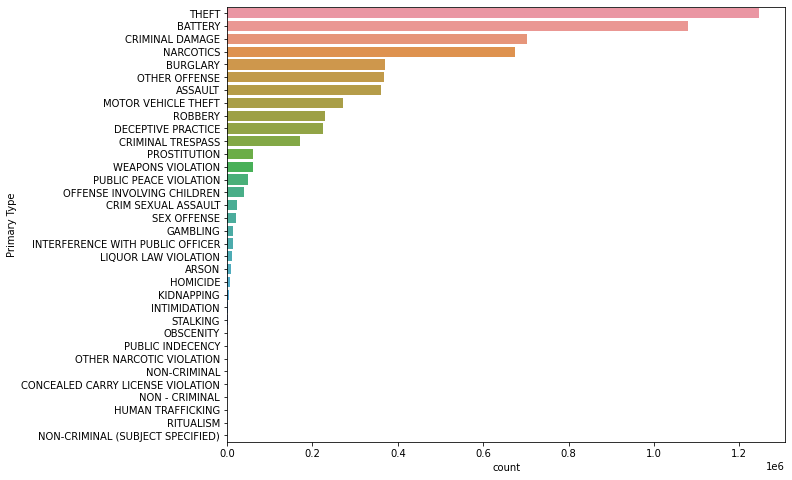

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(data = chicago_df, y='Primary Type', order= chicago_df['Primary Type'].value_counts().index )
plt.show()

### 어디에서 가장 범죄가 많이 발생했는지, 범죄 장소(Location Descripton) 로 비주얼라이징 하시오.

In [ ]:
chicago_df.head(2)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
Date,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False


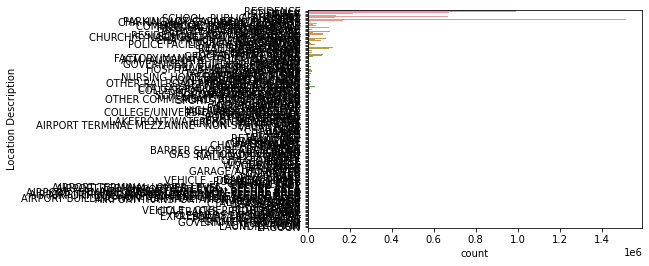

In [ ]:
sns.countplot(data= chicago_df, y= 'Location Description')
plt.show()

In [ ]:
# 너무 많이 나옴
# 범죄 장소가 몇개인지 describe()메소드 사용해서 보기
chicago_df['Location Description'].describe()

count     6015793
unique        161
top        STREET
freq      1517724
Name: Location Description, dtype: object

In [ ]:
# 상위 15개만 가져오기
# ivalue_counts()를 해서 상위 15개의 index만 가져온다
index_15 = chicago_df['Location Description'].value_counts().head(15).index

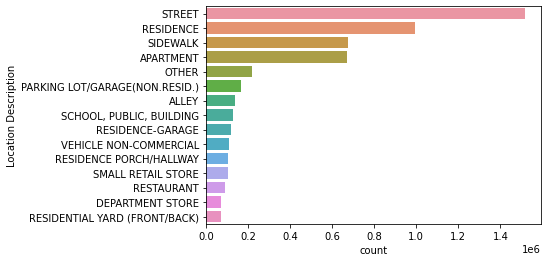

In [ ]:
# 이제 order=파라미터를 지정해서 다시 차트를 그린다
sns.countplot(data= chicago_df, y= 'Location Description', order=index_15)
plt.show()
# 이렇게 하면 15개만 보여준다

### 데이터를 주기별로 분석해 보자

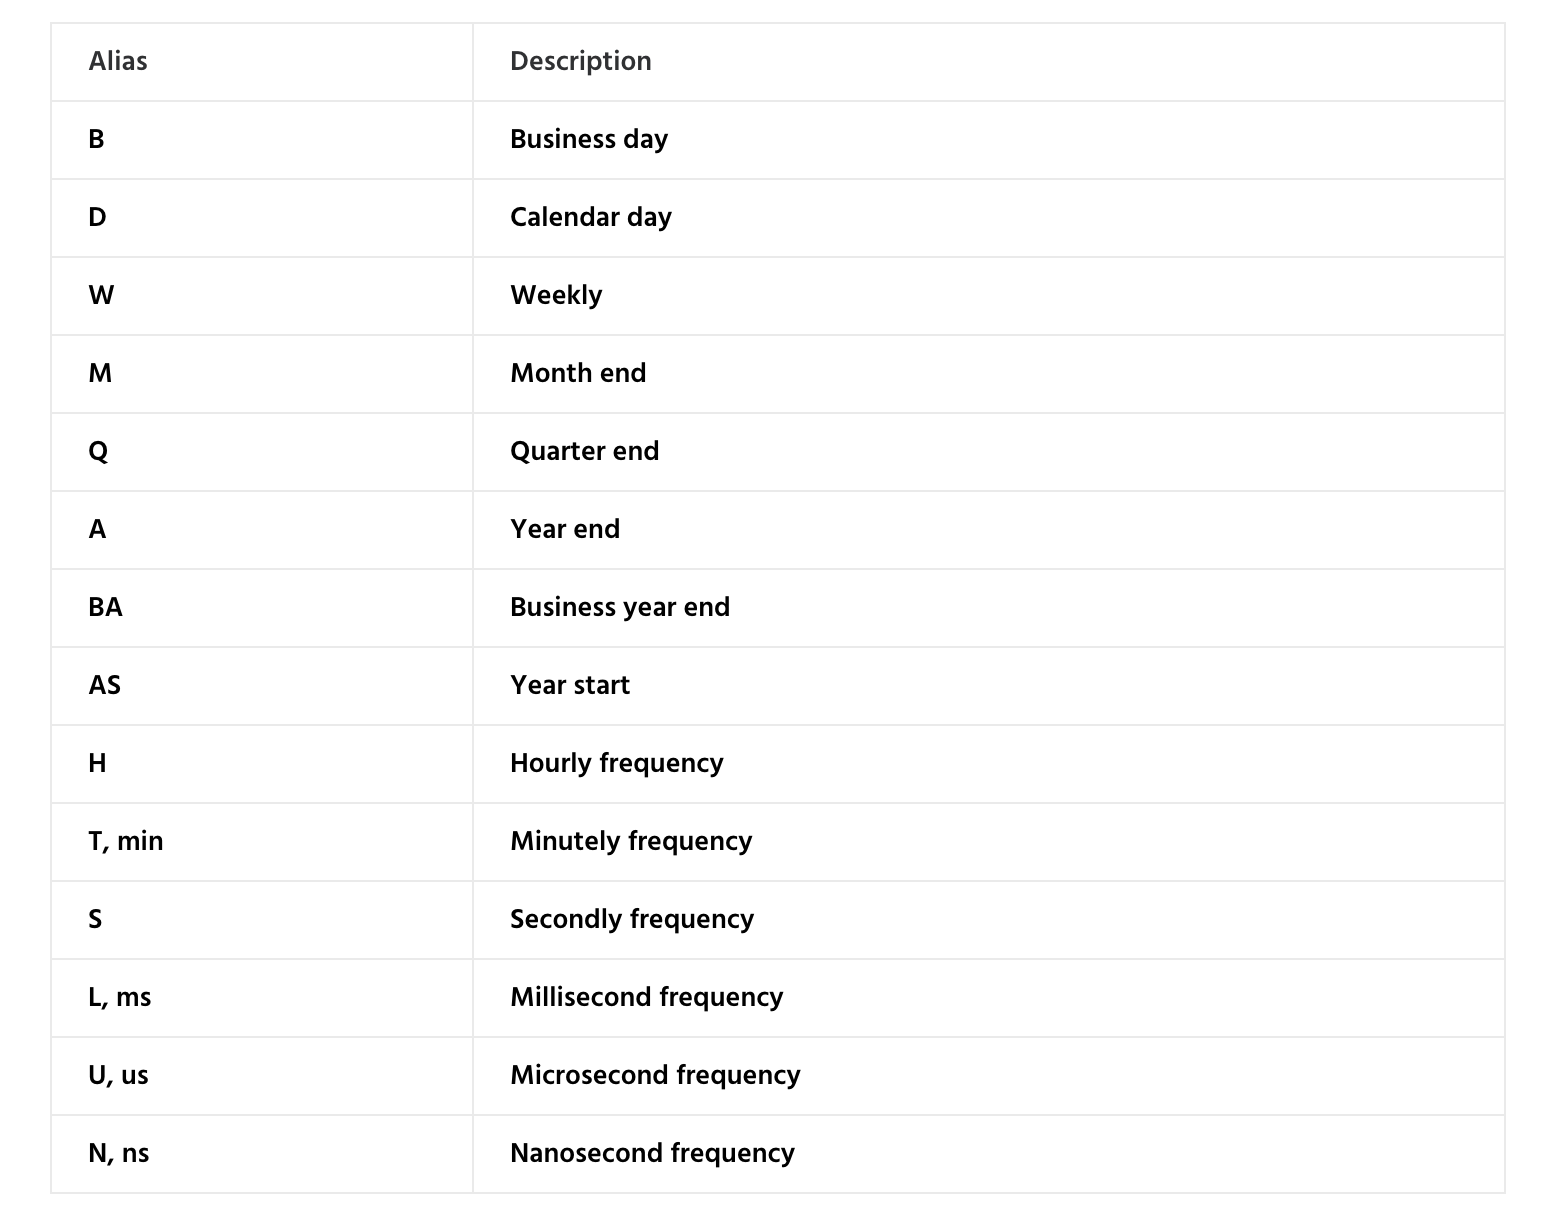

In [ ]:
# resample  'Y' 는 년도다. 년도로 리샘플한 후, 각 년도별 몇개의 범죄 데이터를 가지고 있는지 확인한다.
year_df = chicago_df.resample('Y').size()


In [ ]:
year_df

Date
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

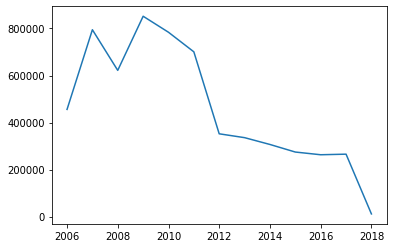

In [ ]:
# 위의 데이터를 plot 으로 시각화 한다. 범죄횟수를 눈으로 확인하자.
plt.plot(year_df)
plt.show()

In [ ]:
chicago_df['Date'].sort_values(ascending= False)
# 년-월-일 시:분:초 의 날짜데이터를 월별로 확인하기

Date
2017-01-18 23:49:00   2017-01-18 23:49:00
2017-01-18 23:45:00   2017-01-18 23:45:00
2017-01-18 23:40:00   2017-01-18 23:40:00
2017-01-18 23:35:00   2017-01-18 23:35:00
2017-01-18 23:30:00   2017-01-18 23:30:00
                              ...        
2005-01-01 00:00:00   2005-01-01 00:00:00
2005-01-01 00:00:00   2005-01-01 00:00:00
2005-01-01 00:00:00   2005-01-01 00:00:00
2005-01-01 00:00:00   2005-01-01 00:00:00
2005-01-01 00:00:00   2005-01-01 00:00:00
Name: Date, Length: 6017767, dtype: datetime64[ns]

In [ ]:
# 월별 범죄 발생 건수를 확인하자.


In [ ]:
# resample 'M' 은 월 에 size()로 데이터를 리샘플
month_df = chicago_df.resample('M').size()

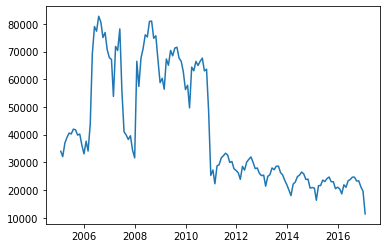

In [ ]:
# 월별 범죄 발생 건수도 plot 으로 시각화 하자.
plt.plot(month_df)
plt.show()

In [ ]:
# 분기별 범죄 리샘플링
quarter_df = chicago_df.resample('Q').size()

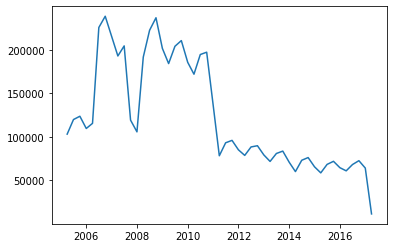

In [ ]:
# 분기별 범죄 건수도 확인하자.
plt.plot(quarter_df)
plt.show()

In [ ]:
# 분기별 범죄 건수도 시각화 하자.


# STEP #3: 데이터 준비

### 원별로(매달 말일) 주기로 하여 데이터프레임을 만들고, 인덱스를 리셋하시오.

In [ ]:
month_df

Date
2005-01-31    33983
2005-02-28    32042
2005-03-31    36970
2005-04-30    38963
2005-05-31    40572
              ...  
2016-09-30    23235
2016-10-31    23314
2016-11-30    21140
2016-12-31    19580
2017-01-31    11357
Freq: M, Length: 145, dtype: int64

In [ ]:
# month_df 의 인덱스를 리셋하고 
# Prophet()을 사용하기 위해서 다시 바꾸는 것


In [ ]:
month_df = month_df.reset_index()

In [ ]:
month_df.head(1)

,Date,0
0,2005-01-31,33983


### 프로펫 라이브러리를 사용하려면, 날짜 컬럼은 'ds' 로, 에측하려는 수치는 'y'로 바꿔야 합니다(필수).

In [ ]:
# 0으로 되어 있는 컬럼명 바뀌
chicago_prophet = month_df.rename(columns={'Date': 'ds', 0: 'y'})


In [ ]:
# 또는 그냥 컬럼 속성을 이용해서 리스트형태로 저장해 준다
# month_df.columns = ['ds', 'y']

# STEP #4: Prophet 으로 예측하기

In [ ]:
from fbprophet import Prophet

In [ ]:
m = Prophet()

In [ ]:
m.fit(chicago_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### [freq 조절 가능한 문자 ](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

[페이스북 프로펫 페이지 예시](https://facebook.github.io/prophet/docs/non-daily_data.html)

In [ ]:
# 36개월로 해서 예측해보자.
future = m.make_future_dataframe(periods=36, freq='M')

In [ ]:
future


,ds
0,2005-01-31
1,2005-02-28
2,2005-03-31
3,2005-04-30
4,2005-05-31
...,...
176,2019-09-30
177,2019-10-31
178,2019-11-30
179,2019-12-31


In [ ]:
forecast = m.predict(future)

In [ ]:
forecast
#yhat 예측결과

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-31,60463.432502,39140.951057,72702.718401,60463.432502,60463.432502,-4803.616721,-4803.616721,-4803.616721,-4803.616721,-4803.616721,-4803.616721,0.0,0.0,0.0,55659.815781
1,2005-02-28,60332.766196,34674.287737,67151.470207,60332.766196,60332.766196,-9480.730557,-9480.730557,-9480.730557,-9480.730557,-9480.730557,-9480.730557,0.0,0.0,0.0,50852.035639
2,2005-03-31,60188.099929,42886.370477,75702.930412,60188.099929,60188.099929,-1254.934724,-1254.934724,-1254.934724,-1254.934724,-1254.934724,-1254.934724,0.0,0.0,0.0,58933.165205
3,2005-04-30,60048.100316,44356.733204,76624.569429,60048.100316,60048.100316,1114.162021,1114.162021,1114.162021,1114.162021,1114.162021,1114.162021,0.0,0.0,0.0,61162.262337
4,2005-05-31,59903.434049,47977.025071,82420.830438,59903.434049,59903.434049,5396.906083,5396.906083,5396.906083,5396.906083,5396.906083,5396.906083,0.0,0.0,0.0,65300.340133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2019-09-30,1558.148796,-14636.601953,19675.968332,835.076467,2396.987728,1881.254355,1881.254355,1881.254355,1881.254355,1881.254355,1881.254355,0.0,0.0,0.0,3439.403151
177,2019-10-31,1144.976555,-13719.468740,19846.094447,378.048414,2020.312247,2481.402454,2481.402454,2481.402454,2481.402454,2481.402454,2481.402454,0.0,0.0,0.0,3626.379010
178,2019-11-30,745.132451,-18531.293823,15522.878607,-63.325169,1657.028553,-2014.976893,-2014.976893,-2014.976893,-2014.976893,-2014.976893,-2014.976893,0.0,0.0,0.0,-1269.844442
179,2019-12-31,331.960210,-23274.264900,11075.263825,-508.623525,1295.906303,-6015.724385,-6015.724385,-6015.724385,-6015.724385,-6015.724385,-6015.724385,0.0,0.0,0.0,-5683.764174


In [ ]:

# 예측 차트 보기

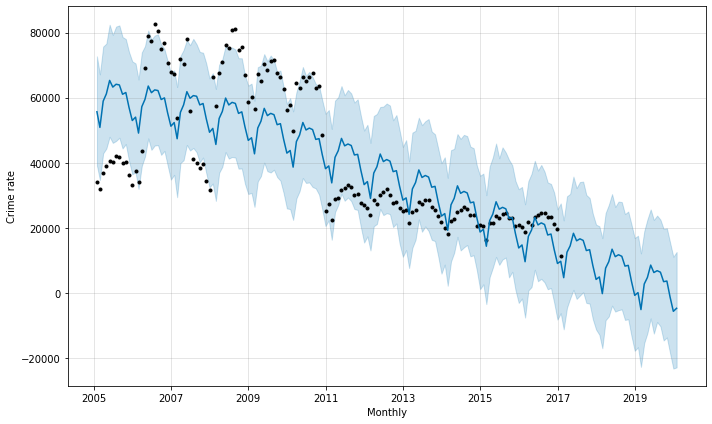

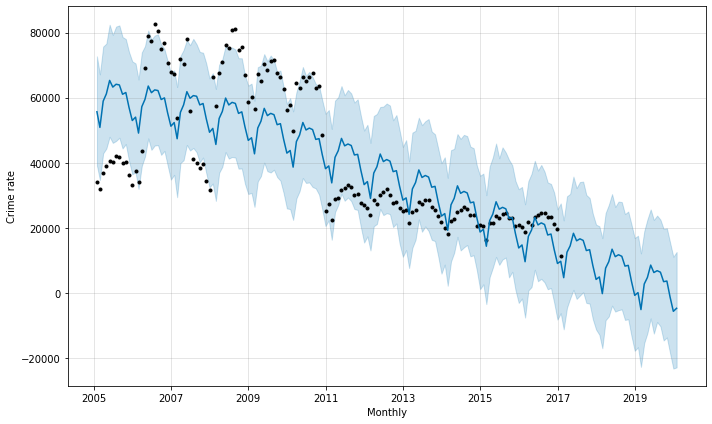

In [ ]:
m.plot(forecast, xlabel='Monthly', ylabel='Crime rate')


In [ ]:
#trend와 yearly 로 보기 plot_components()

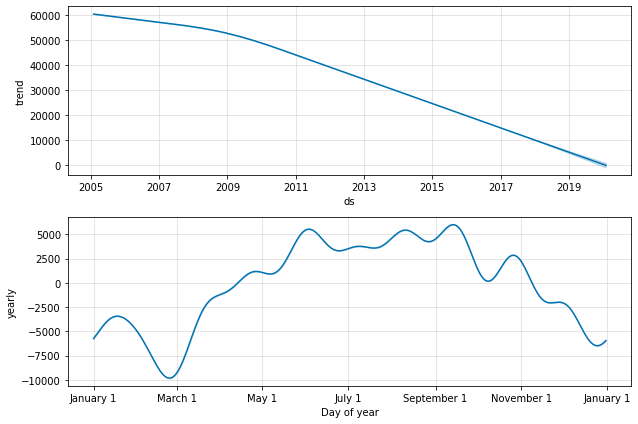

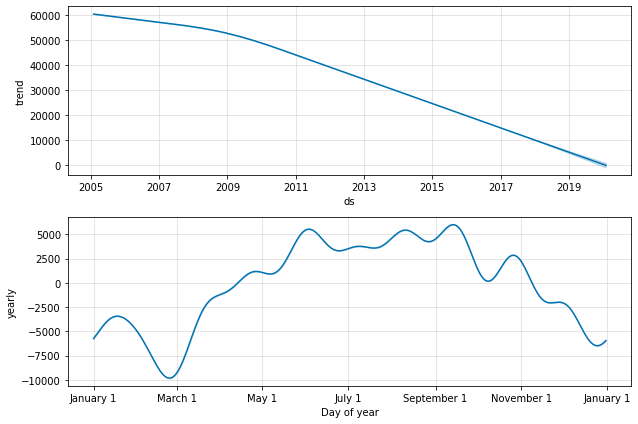

In [ ]:
m.plot_components(forecast)
# trend는 년도에 따라 줄어들고 있고
# yearly 볼 수 있음